<a href="https://colab.research.google.com/github/DeepHMS/Library-Explorer/blob/main/Library_Explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the current landscape of DIA-based proteomics, a high-quality library is essential, whether sourced externally or generated internally through library-free methods. However, these libraries are often vast and challenging to manage or inspect in a spreadsheet due to their size. To address this, we introduce Library Explorer, a tool that enables visualization, exploration, and detailed searching within libraries, allowing users to:

*   Search for specific proteins or peptides (including partial string matches).
*   Extract peptides associated with a particular protein.
*   Generate protein-specific libraries from the main library to develop targeted methods or assess protein coverage.

In [ ]:
from google.colab import drive
import os
import requests
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import seaborn as sns

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Load the Library files
library = pd.read_csv("/content/drive/MyDrive/1.Spectral_Library_Merging/03152025_Tryptic_Output_Library_Library.tsv", sep='\t')
print(library.columns.tolist())

library.head()

['PrecursorMz', 'ProductMz', 'Annotation', 'ProteinId', 'GeneName', 'PeptideSequence', 'ModifiedPeptideSequence', 'PrecursorCharge', 'LibraryIntensity', 'NormalizedRetentionTime', 'PrecursorIonMobility', 'FragmentType', 'FragmentCharge', 'FragmentSeriesNumber', 'FragmentLossType', 'AverageExperimentalRetentionTime', 'AllMappedProteins', 'AllMappedGenes', 'Proteotypic']


,PrecursorMz,ProductMz,Annotation,ProteinId,GeneName,PeptideSequence,ModifiedPeptideSequence,PrecursorCharge,LibraryIntensity,NormalizedRetentionTime,PrecursorIonMobility,FragmentType,FragmentCharge,FragmentSeriesNumber,FragmentLossType,AverageExperimentalRetentionTime,AllMappedProteins,AllMappedGenes,Proteotypic
0,232.150142,175.118953,y1^1,Q04837,SSBP1,VHLLGR,VHLLGR,3,1199.5968,-20.136566,0.6376,y,1,1,NaN,758.245303,sp|Q04837|SSBP_HUMAN,SSBP1,1
1,232.150142,232.140417,y2^1,Q04837,SSBP1,VHLLGR,VHLLGR,3,5952.0160,-20.136566,0.6376,y,1,2,NaN,758.245303,sp|Q04837|SSBP_HUMAN,SSBP1,1
2,232.150142,237.134603,b2^1,Q04837,SSBP1,VHLLGR,VHLLGR,3,8896.4050,-20.136566,0.6376,b,1,2,NaN,758.245303,sp|Q04837|SSBP_HUMAN,SSBP1,1
3,232.150142,298.187367,y5^2,Q04837,SSBP1,VHLLGR,VHLLGR,3,1320.5645,-20.136566,0.6376,y,2,5,NaN,758.245303,sp|Q04837|SSBP_HUMAN,SSBP1,1
4,232.150142,345.224481,y3^1,Q04837,SSBP1,VHLLGR,VHLLGR,3,6752.7173,-20.136566,0.6376,y,1,3,NaN,758.245303,sp|Q04837|SSBP_HUMAN,SSBP1,1


## Library Stat Calculation

In [ ]:
def create_unique_key(library):
    # Define columns based on data type
    object_cols = ['ProductMz', 'Annotation', 'ProteinId', 'GeneName', 'ModifiedPeptideSequence', 'PrecursorCharge']

    # Fill missing values in the DataFrame
    for col in object_cols:
        if library[col].dtype == 'object':  # For string-type columns
            library.loc[:, col] = library[col].fillna('missing')
        else:  # For numeric columns, fill with a default number
            library.loc[:, col] = library[col].fillna(-1)

    # Create the unique key column
    library['Merged'] = library['PrecursorMz'].astype(str) + "_" + \
                        library['ProductMz'].astype(str) + "_" + \
                        library['Annotation'].astype(str) + "_" + \
                        library['ProteinId'].astype(str) + "_" + \
                        library['GeneName'].astype(str) + "_" + \
                        library['ModifiedPeptideSequence'].astype(str) + "_" + \
                        library['PrecursorCharge'].astype(str)

    # Return the number of unique keys
    return library['Merged'].nunique()


df = library.copy()
number_of_unique_keys = create_unique_key(df)

# Extract unique IDs from the 'ProteinId' column
total_rows = library.shape[0]
unique_ids = library['ProteinId'].dropna().unique()
unique_peptide = library['PeptideSequence'].dropna().unique()
mod_peptide = library['ModifiedPeptideSequence'].dropna().unique()
norm_rt = library['NormalizedRetentionTime'].dropna().unique()
ion_mob = library['PrecursorIonMobility'].dropna().unique()

# Print the number of unique Protein IDs
print("Total number of rows in the TSV file:", total_rows)
print("Number of unique keys:", number_of_unique_keys)
print("Number of unique Protein IDs:", len(unique_ids))
print("Number of unique Peptide:", len(unique_peptide))
print("Number of Modified Peptide:", len(mod_peptide))
print("Number of Normalized Retention Time:", len(norm_rt))
print("Number of Ion Mobility:", len(ion_mob))
print()
print("Minimum Normalized Retention Time:", min(norm_rt))
print("Maximum Normalized Retention Time:", max(norm_rt))
print()
print("Minimum Ion Mobility:", min(ion_mob))
print("Maximum Ion Mobility:", max(ion_mob))

Total number of rows in the TSV file: 6184387
Number of unique keys: 6184387
Number of unique Protein IDs: 10357
Number of unique Peptide: 164092
Number of Modified Peptide: 192315
Number of Normalized Retention Time: 201564
Number of Ion Mobility: 249357

Minimum Normalized Retention Time: -63.76360993168082
Maximum Normalized Retention Time: 214.77078922336167

Minimum Ion Mobility: 0.6204799187134791
Maximum Ion Mobility: 1.600216628731371


## Library Data Info Visualization

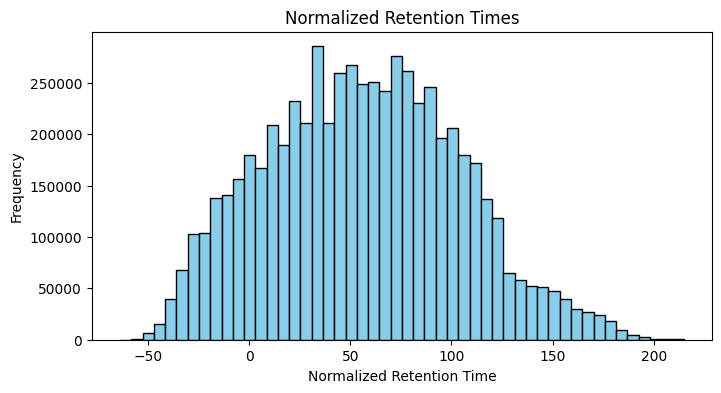

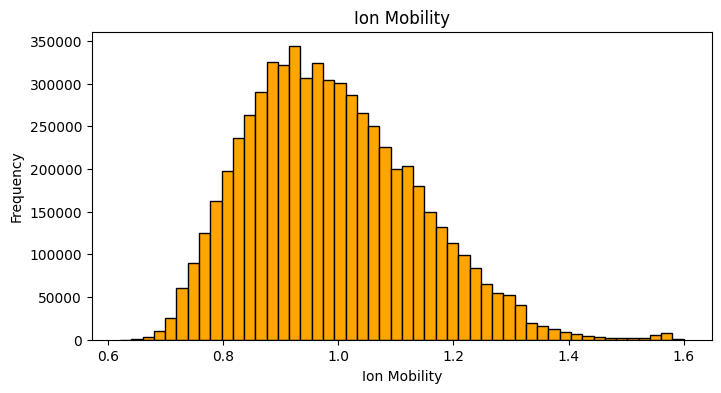

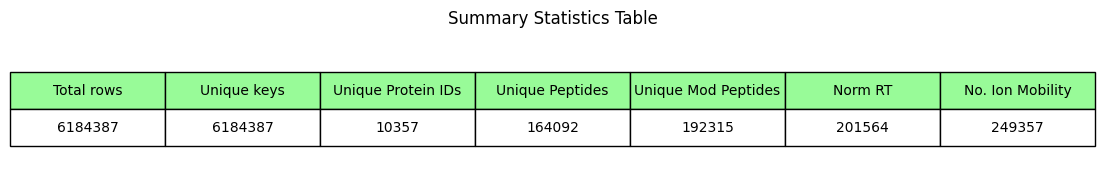

In [ ]:
# Plotting the histogram
plt.figure(figsize=(8, 4))
plt.hist(df['NormalizedRetentionTime'], bins=50, color='skyblue', edgecolor='black')
#sns.histplot(df['NormalizedRetentionTime'], bins=50, kde=True, color='skyblue', edgecolor='black') #with distribution curve (also known as a kernel density estimate, or KDE)
plt.title('Normalized Retention Times')
plt.xlabel('Normalized Retention Time')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df['PrecursorIonMobility'], bins=50, color='orange', edgecolor='black')
#sns.histplot(df['NormalizedRetentionTime'], bins=50, kde=True, color='skyblue', edgecolor='black') #with distribution curve (also known as a kernel density estimate, or KDE)
plt.title('Ion Mobility')
plt.xlabel('Ion Mobility')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Sample data, replace these with your actual values
data = {
    "Total rows": total_rows,
    "Unique keys": number_of_unique_keys,
    "Unique Protein IDs": len(unique_ids),
    "Unique Peptides": len(unique_peptide),
    "Unique Mod Peptides": len(mod_peptide),
    "Norm RT": len(norm_rt),
    "No. Ion Mobility": len(ion_mob)
}

labels = list(data.keys())
values = list(data.values())

# Adjust these parameters
figsize = (14, 2)  # Make figure wider
cell_text_size = 10  # Font size for table cells
title_size = 12  # Font size for the title

# Plot setup
fig, ax = plt.subplots(figsize=figsize)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=[values],
                     colLabels=labels,
                     colColours=["palegreen"]*len(values),  # This colors all columns similarly
                     cellLoc='center',
                     loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(cell_text_size)
the_table.scale(1, 2.2)  # Scale column widths and row heights, adjust as needed

plt.title('Summary Statistics Table', fontsize=title_size)
plt.show()


# Search your **Query Protein** with Partial String of Uniprot ID

In [ ]:
# Get the user input for the initial letters of the UniProt ID and convert it to upper case for case-insensitivity
partial_id = input("Enter the initial part of the UniProt ID: ").upper()

# Ask user for the number of matches they want to see
num_matches = int(input("Enter the number of matching proteins you want to see: "))

# Filter the DataFrame for entries that start with the partial ID in the 'ProteinId' column
# Convert both dataframe column and input to upper case for case-insensitive comparison
matching_ids = library[library['ProteinId'].str.upper().str.startswith(partial_id)]

# Print the matching UniProt IDs
if len(matching_ids) > 0:
    unique_ids = matching_ids['ProteinId'].unique()
    print("Matching UniProt IDs:")
    print(unique_ids)
else:
    print("No matching proteins found with that UniProt ID prefix.")

print()

# Print the matching Protein IDs along with their corresponding 'AllMappedProteins' values
if len(matching_ids) > 0:
    print("Matching Protein IDs and their Mapped Proteins:")
    # Ensure only unique IDs up to the number requested are displayed
    displayed_ids = unique_ids[:num_matches]
    for protein_id in displayed_ids:
        # Fetch the corresponding 'AllMappedProteins' value
        mapped_protein = matching_ids[matching_ids['ProteinId'] == protein_id]['AllMappedProteins'].iloc[0]
        print(f"{protein_id} = {mapped_protein}")
else:
    print("No matching proteins found to display.")

Enter the initial part of the UniProt ID: P10636
Enter the number of matching proteins you want to see: 10
Matching UniProt IDs:
['P10636-0N4R']

Matching Protein IDs and their Mapped Proteins:
P10636-0N4R = sp|P10636-0N4R|0N4R_P301S_biosensor_sequence


In [ ]:
# Get the user input for the initial letters of the UniProt ID and convert it to upper case for case-insensitivity
partial_id = input("Enter the initial part of the UniProt ID: ").upper()

# Ask user for the number of matches they want to see
num_matches = int(input("Enter the number of matching proteins you want to see: "))

# Filter the DataFrame for entries that start with the partial ID in the 'ProteinId' column
# Convert both dataframe column and input to upper case for case-insensitive comparison
matching_ids = library[library['ProteinId'].str.upper().str.startswith(partial_id)]

# Print the matching UniProt IDs
if len(matching_ids) > 0:
    unique_ids = matching_ids['ProteinId'].unique()
    print("Matching UniProt IDs:")
    print(unique_ids)
else:
    print("No matching proteins found with that UniProt ID prefix.")

print()

# Print the matching Protein IDs along with their corresponding 'AllMappedProteins' values
if len(matching_ids) > 0:
    print("Matching Protein IDs and their Mapped Proteins:")
    # Ensure only unique IDs up to the number requested are displayed
    displayed_ids = unique_ids[:num_matches]
    for protein_id in displayed_ids:
        # Check if 'AllMappedProteins' column exists before accessing it
        if 'AllMappedProteins' in matching_ids.columns:
            # Fetch the corresponding 'AllMappedProteins' value
            mapped_protein = matching_ids[matching_ids['ProteinId'] == protein_id]['AllMappedProteins'].iloc[0]
            print(f"{protein_id} = {mapped_protein}")
        else:
            print(f"{protein_id} = 'AllMappedProteins' column not found in matching entries")
else:
    print("No matching proteins found to display.")

Enter the initial part of the UniProt ID: P10637
Enter the number of matching proteins you want to see: 10
Matching UniProt IDs:
['P10637-3']

Matching Protein IDs and their Mapped Proteins:
P10637-3 = 'AllMappedProteins' column not found in matching entries


# Search your **Peptide** with Partial String of Peptide Sequence

In [ ]:
# Get the user input for the initial letters of the Peptide
partial_id = input("Enter the initial part of the Peptide: ").upper()  # Convert input to uppercase for case-insensitive matching

# Ask user for the number of matches they want to see
num_matches = int(input("Enter the number of matching sequences you want to see: "))

# Filter the DataFrame for entries that contain the partial ID anywhere in the 'PeptideSequence' column
# Here, str.contains is used with case=False for case-insensitive search
matching_peptides = library[library['PeptideSequence'].str.contains(partial_id, case=False, na=False)]

# Print the number of mapped entries found out of the total entries
print(f"Found {len(matching_peptides)} matching entries out of {len(library)} total entries.")

# Print the matching Peptides along with their corresponding Protein IDs
if len(matching_peptides) == 0:
    print("No matching peptides found.")
else:
    print("Matching Peptides and Protein IDs:")
    # Limit the output to the number of matches requested by the user
    for index, row in matching_peptides.head(num_matches).iterrows():
        print(f"{row['PeptideSequence']} - {row['ProteinId']}")

Enter the initial part of the Peptide: AKSD
Enter the number of matching sequences you want to see: 5
Found 90 matching entries out of 6151063 total entries.
Matching Peptides and Protein IDs:
AQLGGPEAAKSDETAAK - P04792
AQLGGPEAAKSDETAAK - P04792
AQLGGPEAAKSDETAAK - P04792
AQLGGPEAAKSDETAAK - P04792
AQLGGPEAAKSDETAAK - P04792


# Find Proteins against your Query Peptide Sequence

In [ ]:
# Get the user input for the complete Peptide sequence
full_peptide = input("Enter the complete Peptide sequence: ")

# Filter the DataFrame for entries that exactly match the user's input in the 'PeptideSequence' column
matching_entries = library[library['PeptideSequence'] == full_peptide]

# Get the unique Protein IDs associated with the matching peptide
unique_proteins = matching_entries['ProteinId'].unique()

# Print the number of unique proteins found and their names
print(f"Number of unique proteins found: {len(unique_proteins)}")
if len(unique_proteins) > 0:
    print("Protein IDs:")
    for protein in unique_proteins:
        print(protein)
else:
    print("No proteins found for the given peptide.")


Enter the complete Peptide sequence: AQLGGPEAAKSDETAAK
Number of unique proteins found: 1
Protein IDs:
P04792


# Library Merging

In [ ]:
# Read the TSV files using pandas with tab as the separator
library_1 = pd.read_csv('/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Library_Modification/Renamed_Tryptic_HEK_Mutant_0N4R_library.tsv', sep='\t')
library_2 = pd.read_csv('/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Library_Modification/Heavy_Label_TAU_Construct_library.tsv', sep='\t')

# Concatenate the two dataframes
merged_df = pd.concat([library_1, library_2], ignore_index=True)

# Specify the path for the output merged file
output_path = '/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Library_Modification/Merged_library.tsv'
merged_df.to_csv(output_path, sep='\t', index=False)

# Print the number of rows in each library
print(f"Number of rows in Library 1: {len(library_1)}")
print(f"Number of rows in Library 2: {len(library_2)}")
print(f"Number of rows in the merged library: {len(merged_df)}")

print("The files have been successfully merged and saved as a TSV file to:", output_path)


Number of rows in Library 1: 6151063
Number of rows in Library 2: 6066
Number of rows in the merged library: 6157129
The files have been successfully merged and saved as a TSV file to: /content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Library_Modification/Merged_library.tsv


# Query Protein Renaming in the Library

In [ ]:
# Load the TSV file
file_path = '/content/drive/MyDrive/1.Spectral_Library_Merging/03152025_Phospho_Tryptic_Output_Library.tsv'  # Update this path to your actual file location

# Read the TSV file into a DataFrame
library = pd.read_csv(file_path, sep='\t')

# Function to query and rename the protein ID in the DataFrame
def query_and_rename_protein(library, query_protein_id, query_AllMappedProteins, renamed_protein_id, renamed_AllMappedProteins):
    # Count total rows before renaming
    total_rows_before = len(library)
    print(f"Total rows before renaming: {total_rows_before}")

    # Check if the ProteinId is present in the DataFrame
    if query_protein_id in library['ProteinId'].values:
        # Count rows for the specified Protein ID
        rows_for_protein = len(library[library['ProteinId'] == query_protein_id])
        print(f"Rows with Protein ID '{query_protein_id}': {rows_for_protein}")

        # Rename the specified ProteinId
        library['ProteinId'] = library['ProteinId'].replace(query_protein_id, renamed_protein_id)

        # Additionally, rename the entries in 'AllMappedProteins' that match the query_protein_id
        library['AllMappedProteins'] = library['AllMappedProteins'].replace(query_AllMappedProteins, renamed_AllMappedProteins)

        # Count total rows after renaming
        total_rows_after = len(library)
        print(f"Protein ID '{query_protein_id}' has been renamed to '{renamed_protein_id}' in both 'ProteinId' and 'AllMappedProteins'.")
        print(f"Total rows after renaming: {total_rows_after}")

    else:
        print(f"Protein ID '{query_protein_id}' not found in the library.")
        # Even if not found, print total rows
        total_rows_after = len(library)
        print(f"Total rows (no change): {total_rows_after}")

    return library

# Ask user for the ProteinId to search and the new ID to rename it to
query_protein_id = input("Please enter your Query Uniprot ID to search for: ")
renamed_protein_id = input("Please enter your ID which you want to rename with: ")
query_AllMappedProteins = input("Please enter your Query AllMappedProteins to search for: ")
renamed_AllMappedProteins = input("Please enter your AllMappedProteins which you want to rename with: ")

# Call the function to search and rename the protein ID
updated_library = query_and_rename_protein(library, query_protein_id, query_AllMappedProteins, renamed_protein_id, renamed_AllMappedProteins)

# Save the updated DataFrame back to the TSV file
updated_library.to_csv('/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Library_Modification/Renamed_Tryptic_HEK_Mutant_0N4R_library.tsv', sep='\t', index=False)


Total rows before renaming: 6151063
Rows with Protein ID 'P10636-0N4R': 4818
Protein ID 'P10636-0N4R' has been renamed to 'Custom_Tau_Construct' in both 'ProteinId' and 'AllMappedProteins'.
Total rows after renaming: 6151063


# Mining of library for your Query Protein

In [ ]:
library = pd.read_csv('/content/drive/MyDrive/1.Spectral_Library_Merging/03152025_Phospho_Tryptic_Output_Library.tsv', sep='\t')

# Ask user for the ProteinId to search
protein_id = input("Please enter your Query Uniprot ID to search for: ")

def query_protein(library):

    # Check if the ProteinId is present in the DataFrame
    if protein_id in library['ProteinId'].values:
        # Extract data for the input ProteinId
        protein_data = library[library['ProteinId'] == protein_id]

        # Define the output path with the protein_id as the filename
        output_path = f"/content/{protein_id}_library.tsv"
        protein_data.to_csv(output_path, sep='\t', index=False)
        print(f"Data successfully saved to {output_path}")

        # Optional: Download the CSV file if in a Colab environment
        try:
            from google.colab import files
            files.download(output_path)
            print("Processing complete. CSV file is ready for download.")
        except ImportError:
            print("Google Colab libraries not available. File saved locally.")

        return protein_data  # Return the DataFrame containing the queried data
    else:
        print("ProteinID '{}' is not present in the Data.".format(protein_id))
        return None  # Return None if the protein ID is not found

# Example of calling the function and storing the result
result_df = query_protein(library)
if result_df is not None:
    # If result_df is not None, you can perform additional operations here
    print("Dataframe is ready for further processing.")

Please enter your Query Uniprot ID to search for: P10636-0N4R
Data successfully saved to /content/P10636-0N4R_library.tsv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing complete. CSV file is ready for download.
Dataframe is ready for further processing.


# Mining of library for Multiple Query Protein

In [ ]:
# Function to load and clean library data
def load_library(path):
    library = pd.read_csv(path, sep='\t')
    # Strip whitespace from headers and ProteinId values
    library.columns = library.columns.str.strip()
    library['ProteinId'] = library['ProteinId'].str.strip()
    return library

# Function to query protein IDs
def query_protein(library, protein_ids):
    """Query the DataFrame for given Protein IDs and save the results in a single TSV format."""
    # Normalize input IDs by stripping any potential whitespace
    protein_ids = [id.strip() for id in protein_ids]
    found_data = library[library['ProteinId'].isin(protein_ids)]
    found_protein_ids = found_data['ProteinId'].unique()

    # Determine which IDs were not found
    not_found_ids = [id for id in protein_ids if id not in found_protein_ids]
    if not_found_ids:
        print("Warning: The following Protein IDs were not found in the dataset:", ', '.join(not_found_ids))

    if not found_data.empty:
        output_path = "/content/Query_Protein_Library.tsv"
        found_data.to_csv(output_path, index=False, sep='\t')
        print(f"Data successfully saved to {output_path}")
        # Optional: Download the TSV file if in a Colab environment
        try:
            from google.colab import files
            files.download(output_path)
        except ImportError:
            print("libraries not available. File saved locally.")
    else:
        print("No valid Protein IDs found.")

# Get user input
choice = input("Select 1 for one protein and 2 for multiple proteins: ").strip()
if choice == "1":
    protein_id = input("Please enter your Query UniProt ID to search for: ").strip()
    protein_ids = [protein_id]
elif choice == "2":
    protein_ids_input = input("Enter UniProt IDs separated by a space: ").strip()
    protein_ids = protein_ids_input.split()
else:
    print("Invalid choice. Please enter 1 or 2.")
    protein_ids = []

# Query the library if IDs were provided
if protein_ids:
    result_df = query_protein(library, protein_ids)


Select 1 for one protein and 2 for multiple proteins: 2
Enter UniProt IDs separated by a space: P04792 P04792
Data successfully saved to /content/Query_Protein_Library.tsv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fetching FASTA sequence of Query Protein

In [ ]:
def fetch_fasta(protein_id):
    """Fetch the FASTA sequence for a given protein ID from UniProt."""
    url = f"https://www.uniprot.org/uniprot/{protein_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta = ''.join(response.text.split('\n')[1:]).replace('\n', '').strip()
        return fasta
    else:
        print(f"Failed to retrieve FASTA sequence with status code: {response.status_code}")
        return None

def main():
    print("Do you want to fetch the FASTA sequence from UniProt?")
    print("Type 'YES' to automatically fetch the FASTA sequence for a given Protein ID from UniProt.")
    print("Type 'NO' if you prefer to manually enter the FASTA sequence.")

    choice = input("Enter your choice (YES/NO): ").strip().upper()

    if choice == "YES":
        protein_id = input("Please enter your Query Uniprot ID to search for: ").strip()
        fasta_sequence = fetch_fasta(protein_id)
        if not fasta_sequence:
            print("No FASTA sequence was retrieved.")
            return
    elif choice == "NO":
        fasta_sequence = input("Please paste the Protein sequence here in Upper Case: ").strip().upper()
        # Ensure only alphabetic characters are included
        fasta_sequence = ''.join([char for char in fasta_sequence if char.isalpha()])
        if not fasta_sequence:
            print("No valid input was provided. Please ensure the input format is only the protein sequence in Upper Case.")
            print("Example: MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEP.")
            return
    else:
        print("Invalid input. Please type 'YES' or 'NO'.")
        return

    if fasta_sequence:
        # Convert sequence into a single line without spaces
        single_line_sequence = "".join(fasta_sequence.splitlines()).replace(" ", "")
        print(f'("{single_line_sequence}")')
    else:
        print("No FASTA sequence was retrieved or input.")

if __name__ == "__main__":
    main()

Do you want to fetch the FASTA sequence from UniProt?
Type 'YES' to automatically fetch the FASTA sequence for a given Protein ID from UniProt.
Type 'NO' if you prefer to manually enter the FASTA sequence.
Enter your choice (YES/NO): YES
Please enter your Query Uniprot ID to search for: P04792
("MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITGKHEERQDEHGYISRCFTRKYTLPPGVDPTQVSSSLSPEGTLTVEAPMPKLATQSNEITIPVTFESRAQLGGPEAAKSDETAAK")


# Query Protein based FASTA Sequence Mapping with peptides in the Library

In [ ]:
# Ensure you have defined peptide_list correctly somewhere in the global scope
peptide_list = """SEKLDFK
LTFRENAK
IPAKTPPAPK
GQANATRIPAK
KLDLSNVQSK
TDHGAEIVYK
SEKLDFKDR
IGSTENLKHQPGGGK
TPSLPTPPTREPKK
LDFKDRVQSK
SRTPSLPTPPTREPK
VQIINKK
IGSLDNITHVPGGGNKK
GQANATRIPAKTPPAPK
IGSTENLK
PGGGQVEVK
SRTPSLPTPPTR
AKTDHGAEIVYK
GAAPPGQKGQANATRIPAK
HQPGGGKVQIINK
TPPSSGEPPKSGDR
TPSLPTPPTREPK
GAAPPGQKGQANATR
CGSLGNIHHKPGGGQVEVK
HVSGGGSVQIVYKPVDLSK
TPPSSGEPPK
LDLSNVQSK
SRLQTAPVPMPDLK
IGSLDNITHVPGGGNK
TPSLPTPPTR
SKIGSTENLK
QEFEVMEDHAGTYGLGDRK
SPVVSGDTSPR
TDHGAEIVYKSPVVSGDTSPR
KDQGGYTMHQDQEGDTDAGLK
IGSLDNITHVPGGGNKKIETHK
LQTAPVPMPDLK
HVSGGGSVQIVYK
AEPRQEFEVMEDHAGTYGLGDRK
QEFEVMEDHAGTYGLGDR
SGYSSPGSPGTPGSR
DQGGYTMHQDQEGDTDAGLK
AEEAGIGDTPSLEDEAAGHVTQAR
HLSNVSSTGSIDMVDSPQLATLADEVSASLAK
AEPRQEFEVMEDHAGTYGLGDR
QEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLK
SGDRSGYSSPGSPGTPGSR
DQGGYTMHQDQEGDTDAGLKAEEAGIGDTPSLEDEAAGHVTQAR
KDQGGYTMHQDQEGDTDAGLKAEEAGIGDTPSLEDEAAGHVTQAR
"""

# Ask user for the UniProt Protein ID to use for Map Title
protein_id = input("Please enter your UniProt Name for using it : ")

# Ask user for a list of peptides, with one space between each peptide
peptide_input = input("Please enter a list of peptides separated by a space: ")

# Convert the space-separated string of peptides into a list
peptide_list = peptide_input.split()

def fetch_fasta(protein_id):
    """Fetch the FASTA sequence for a given protein ID from UniProt."""
    url = f"https://www.uniprot.org/uniprot/{protein_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta = ''.join(response.text.split('\n')[1:]).replace('\n', '').strip()
        return fasta
    else:
        print(f"Failed to retrieve FASTA sequence with status code: {response.status_code}")
        return None

def convert_to_peptide_list(peptide_string):
    # Split the peptide string by newlines, and strip any leading/trailing spaces
    peptides = [peptide.strip() for peptide in peptide_string.strip().split("\n") if peptide.strip()]
    return peptides

def calculate_coverage(fasta_sequence, peptides):
    coverage = np.zeros(len(fasta_sequence), dtype=int)
    # Find each peptide in the sequence and mark it
    for peptide in peptides:
        for match in re.finditer(peptide, fasta_sequence):
            start, end = match.start(), match.end()
            coverage[start:end] = 1  # Mark covered region
    # Calculate the coverage percentage
    covered_amino_acids = np.sum(coverage)  # Number of amino acids covered by peptides
    total_amino_acids = len(fasta_sequence)  # Total number of amino acids in the sequence
    coverage_percentage = (covered_amino_acids / total_amino_acids) * 100
    return coverage_percentage, covered_amino_acids, total_amino_acids, coverage

def visualize_mapping(fasta_sequence, coverage, coverage_percentage, line_length=50):
    # Break the sequence into multiple lines (50 amino acids per line)
    seq_chunks = [fasta_sequence[i:i+line_length] for i in range(0, len(fasta_sequence), line_length)]
    coverage_chunks = [coverage[i:i+line_length] for i in range(0, len(coverage), line_length)]

    # Adjust figure size based on number of lines
    num_lines = len(seq_chunks)
    fig, ax = plt.subplots(figsize=(16, num_lines * 0.5))  # Adjusted figure size for less white space

    # Create a grid for the text, each character occupies its own square
    for line_idx, (seq_chunk, coverage_chunk) in enumerate(zip(seq_chunks, coverage_chunks)):
        start_num = line_idx * line_length + 1  # Starting number for the current line
        end_num = min(start_num + line_length - 1, len(fasta_sequence))  # Ending number for the current line

        # Display sequence and coverage with colors and boldness
        for i, char in enumerate(seq_chunk):
            color = 'royalblue' if coverage_chunk[i] == 1 else 'black'  # Red for covered, black for non-covered
            weight = 'bold' if coverage_chunk[i] == 1 else 'normal'  # Bold for covered, normal for non-covered
            ax.text(i + 1, num_lines - line_idx - 1, char, va='center', ha='center', color=color, fontsize=12, fontweight=weight)

        # Add the start and end numbers on the sides of the sequence with smaller font size
        ax.text(-0.8, num_lines - line_idx - 0.8, str(start_num), va='center', ha='right', fontsize=11, fontweight='normal')
        ax.text(line_length + 1, num_lines - line_idx - 0.8, str(end_num), va='center', ha='left', fontsize=11, fontweight='normal')

    # Set the aspect ratio to make it grid-like and uniform
    ax.set_aspect('equal')

    # Add a black border around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('white')  # Set border color to black
        spine.set_linewidth(2)        # Set border thickness

    # Adjust x and y limits to add space around the sequence and reduce overlap with the borders
    ax.set_xlim(-2, line_length + 2)  # Reduced the white space on both sides
    ax.set_ylim(-0.5, num_lines - 0.5)

    # Add padding (white space)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)  # Reduced padding for less white space

    # Add the title outside the border, showing coverage percentage
    plt.suptitle(f'Coverage of {protein_id} : {coverage_percentage:.2f}%', fontsize=14, y=0.82, weight ='bold')

    # Hide the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Save the figure with transparency
    #plt.savefig(f'Coverage of {protein_id}.png', transparent=True, bbox_inches='tight', dpi=600)

    # Show the plot after saving
    plt.show()

def main():
    choice = input("Fetch FASTA from UniProt? (YES/NO): ").strip().upper()
    if choice == "YES":
        protein_id = input("Enter UniProt ID: ").strip()
        fasta_sequence = fetch_fasta(protein_id)
        if not fasta_sequence:
            return
    elif choice == "NO":
        fasta_sequence = input("Paste the Protein sequence: ").replace(" ", "").strip().upper()
    else:
        print("Invalid input. Please type 'YES' or 'NO'.")
        return

    if fasta_sequence:
        # Presumably, Peptide_list is supposed to be the peptides_string
        peptides_string = Peptide_list
        peptides = convert_to_peptide_list(peptides_string)
        coverage_percentage, covered_amino_acids, total_amino_acids, coverage = calculate_coverage(fasta_sequence, peptides)
        visualize_mapping(fasta_sequence, coverage, coverage_percentage)  # Pass only the necessary arguments
    else:
        print("No valid sequence input.")

    print()

    #### Peptide Mapping Status

    # Total number of peptides
    total_peptides = len(peptides)

    # Count peptides that map to the FASTA sequence
    mapped_peptides = [peptide for peptide in peptides if peptide in fasta_sequence]
    num_mapped = len(mapped_peptides)

    # Identify non-mapped peptides
    not_mapped_peptides = [peptide for peptide in peptides if peptide not in fasta_sequence]
    num_not_mapped = len(not_mapped_peptides)

    # Calculate percentage of peptides mapped
    percentage_mapped = (num_mapped / total_peptides) * 100

    # Print results
    print(f"Total peptides: {total_peptides}")
    print(f"Number of peptides that map to the FASTA sequence: {num_mapped}")
    print(f"Number of peptides that do not map to the FASTA sequence: {num_not_mapped}")

    print()

    print(f"\nMapped peptides:{num_mapped}")
    for peptide in mapped_peptides:
        print(peptide)

    print()

    print(f"\nNon-mapped peptides:{num_not_mapped}")
    for peptide in not_mapped_peptides:
        print(peptide)

if __name__ == "__main__":
    main()


Please enter your UniProt Name for using it : P01636


KeyboardInterrupt: Interrupted by user

For Spectronaut

In [ ]:
#'ReferenceRun', 'PrecursorCharge', 'Workflow', 'IntModifiedPeptide', 'CV',
# 'AllowForNormalization', 'ModifiedPeptide', 'StrippedPeptide', 'iRT', 'IonMobility',
# 'iRTSourceSpecific', 'BGSInferenceId', 'IsProteotypic', 'IntLabeledPeptide', 'LabeledPeptide',
# 'PrecursorMz', 'ReferenceRunQvalue', 'ReferenceRunMS1Response', 'FragmentLossType',
# 'FragmentNumber', 'FragmentType', 'FragmentCharge', 'FragmentMz', 'RelativeIntensity',
# 'ExcludeFromAssay', 'Database', 'ProteinGroups', 'UniProtIds', 'Protein Name', 'ProteinDescription',
# 'Organisms', 'OrganismId', 'Genes', 'Protein Existence', 'Sequence Version', 'FASTAName']


def create_unique_key(library):
    # Define columns based on data type
    object_cols = ['FragmentMz', 'UniProtIds', 'Genes', 'ModifiedPeptide', 'PrecursorCharge']

    # Fill missing values in the DataFrame
    for col in object_cols:
        if library[col].dtype == 'object':  # For string-type columns
            library.loc[:, col] = library[col].fillna('missing')
        else:  # For numeric columns, fill with a default number
            library.loc[:, col] = library[col].fillna(-1)

    # Create the unique key column
    library['Merged'] = library['PrecursorMz'].astype(str) + "_" + \
                        library['FragmentMz'].astype(str) + "_" + \
                        library['UniProtIds'].astype(str) + "_" + \
                        library['Genes'].astype(str) + "_" + \
                        library['ModifiedPeptide'].astype(str) + "_" + \
                        library['PrecursorCharge'].astype(str)

    # Return the number of unique keys
    return library['Merged'].nunique()


df = library.copy()
number_of_unique_keys = create_unique_key(df)

# Extract unique IDs from the 'ProteinId' column
total_rows = library.shape[0]
unique_ids = library['UniProtIds'].dropna().unique()
unique_peptide = library['StrippedPeptide'].dropna().unique()
mod_peptide = library['ModifiedPeptide'].dropna().unique()
norm_rt = library['iRT'].dropna().unique()
ion_mob = library['IonMobility'].dropna().unique()

# Print the number of unique Protein IDs
print("Total number of rows in the TSV file:", total_rows)
print("Number of unique keys:", number_of_unique_keys)
print("Number of unique Protein IDs:", len(unique_ids))
print("Number of unique Peptide:", len(unique_peptide))
print("Number of Modified Peptide:", len(mod_peptide))
print("Number of Normalized Retention Time:", len(norm_rt))
print("Number of Ion Mobility:", len(ion_mob))
print()
print("Minimum Normalized Retention Time:", min(norm_rt))
print("Maximum Normalized Retention Time:", max(norm_rt))
print()
print("Minimum Ion Mobility:", min(ion_mob))
print("Maximum Ion Mobility:", max(ion_mob))

Total number of rows in the TSV file: 2548584
Number of unique keys: 2548498
Number of unique Protein IDs: 9550
Number of unique Peptide: 86659
Number of Modified Peptide: 96745
Number of Normalized Retention Time: 85815
Number of Ion Mobility: 113383

Minimum Normalized Retention Time: -57.72689
Maximum Normalized Retention Time: 286.48672

Minimum Ion Mobility: 0.6631075
Maximum Ion Mobility: 1.5782531


In [ ]:


# Read the TSV files using pandas with tab as the separator
library_1 = pd.read_csv("/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Tryptic_HEK_Mutant_0N4R_library.tsv", sep='\t')
library_2 = pd.read_csv("/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Tryptic_HEK_Mutant_0N4R_library.tsv", sep='\t')

# Concatenate the two dataframes
merged_df = pd.concat([library_1, library_2], ignore_index=True)

# Specify the path for the output merged file
output_path = '/content/drive/MyDrive/5.Single_Cell_Proteomics/0N4R_Analysis/Library/Merged_library.tsv'
merged_df.to_csv(output_path, sep='\t', index=False)

print("The files have been successfully merged and saved as a TSV file to:", output_path)
